# get the most likely path (MLP)

In [1]:
# contruct a trace of labels from the answer
# we also have a transition possibility state

# navigate through the graph
# go for the label. if two nodes with same label? select the one with the highest probability
# finish when the path contradicts the answer
import pickle

filename = 'cat'

In [2]:
# open the journey data
with open(f'../data/{filename}_journeys.pkl', 'rb') as f:
    journeys = pickle.load(f)

In [3]:
import random

# create a transition dictionary
transition_dict = {}

# random sample 80% from journeys
random.shuffle(journeys)
journeys_train = journeys[:int(len(journeys)*0.8)]
journeys_test = journeys[int(len(journeys)*0.8):]

for journey in journeys_train:
    for i in range(len(journey)-1):
        if journey[i] not in transition_dict:
            transition_dict[journey[i]] = {}
        transition_dict[journey[i]][journey[i+1]] = transition_dict[journey[i]].get(journey[i+1], 0) + 1

In [4]:
# create a trace of labels
traces = []

for journey in journeys:
    traces.append(list(map(lambda x: x.split('__')[0], journey)))

traces_train = traces[:int(len(traces)*0.8)]
traces_test = traces[int(len(traces)*0.8):]

In [6]:
# load a graph with pickle
with open(f'../../Dominators/graphs/{filename}_combined_graph.pkl', 'rb') as f:
    G = pickle.load(f)

In [7]:
end = set()
start = set()

for i in range(len(journeys)):
    start.add(journeys[i][0])
    end.add(journeys[i][-1])

if len(start) == 1 and len(end) == 1:
    print('all journeys start and end with the same node')
    start = start.pop()
    end = end.pop()
else:
    raise Exception('journeys do not start and end with the same node')

all journeys start and end with the same node


In [8]:
import numpy as np
from tqdm import tqdm

# do bfs with backtracking
def dfs(curr_length, past_nodes):
    global G
    global done, iter_count, answer

    # if the current node is the end node with the correct length, finish
    if done or (curr_length == len(traces_test[iter_count]) and past_nodes[-1] == end):
        if not done:
            done = True
            answer = past_nodes
        return
    
    # get the next node
    next_label = traces_test[iter_count][curr_length]
    candidate_nodes = []
    for node in G[past_nodes[-1]]:
        if node.split('__')[0] == next_label:
            candidate_nodes.append(node)
    try:
        candidate_nodes.sort(key=lambda x: transition_dict.get(past_nodes[-1], dict()).get(x, 0), reverse=True)
    except:
        print(past_nodes[-1], candidate_nodes, transition_dict[past_nodes[-1]])


    for node in candidate_nodes:
        dfs(curr_length+1, past_nodes + [node])

In [9]:
answers = []

for i in tqdm(range(len(journeys_test))):
    iter_count = i
    answer = []
    done = False
    dfs(1, [start])
    answers.append(answer)

100%|██████████| 200000/200000 [01:39<00:00, 2017.03it/s]


In [85]:
for i in range(len(answers[1])):
    # print the first deviation
    if answers[1][i] != journeys_test[1][i]:
        print(f'first deviation at {i}')
        print(f'answer: {answers[1][i]}')
        print(f'journey: {journeys_test[1][i]}')
        break

first deviation at 60
answer: 0xeff6b0___349
journey: 0xeff6b0___348


In [10]:
import numpy as np

corrects = []
for i in range(len(answers)):
    for j in range(len(answers[i])):
        # calculate the first wrong index
        if answers[i][j] == journeys_test[i][j] and j == len(answers[i])-1:
            corrects.append(1)
        elif answers[i][j] != journeys_test[i][j]:
            corrects.append(j / len(answers[i]))
            break

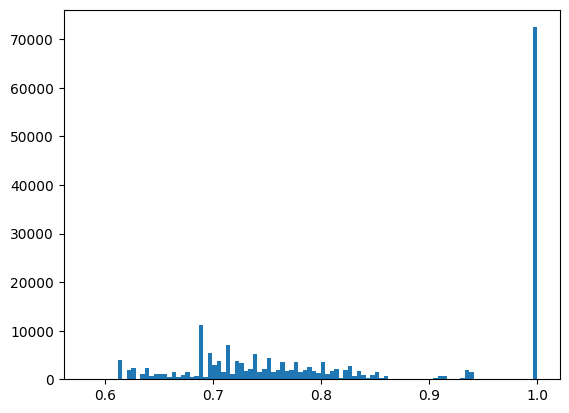

0.8334805876420003

In [11]:
# plot the distribution of corrects
import matplotlib.pyplot as plt

plt.hist(corrects, bins=100)
plt.show()
np.mean(corrects)